In [1]:
import pandas as pd
import pyranges as pr

In [2]:
matrix = pd.read_parquet("data/GSE49828_methylation_matrix.parquet")
# List of chromosomes in order
ordered_chrs = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

# Make it a Categorical for correct sorting
matrix["chr"] = pd.Categorical(matrix["chr"], categories=ordered_chrs, ordered=True)
matrix.head()

,chr,cpg_pos,1st_PB1,1st_PB2,1st_PB3,2-cell1,2-cell2,2nd_PB1,2nd_PB2,4-cell1,...,Postimplantation_embryo3,Sperm1,Sperm2,Sperm3,Sperm4,TE1,TE2,TE3,Zygote1,Zygote2
0,chr1,10609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,10617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,10620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,10631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,10867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# CpG island annotation

In [3]:
!mkdir -p annotations
!wget -O annotations/cpgIslandExt.hg19.bed \
  "https://hgdownload.soe.ucsc.edu/goldenPath/hg19/database/cpgIslandExt.txt.gz"

# Convert to BED: chr, start, end
!zcat annotations/cpgIslandExt.hg19.bed | awk 'BEGIN{OFS="\t"} {print $2,$3,$4}' > annotations/cpg_islands.bed


--2025-07-04 12:58:45--  https://hgdownload.soe.ucsc.edu/goldenPath/hg19/database/cpgIslandExt.txt.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680141 (664K) [application/x-gzip]
Saving to: ‘annotations/cpgIslandExt.hg19.bed’

annotations/cpgIsla 100%[===================>] 664.20K   787KB/s    in 0.8s    

2025-07-04 12:58:50 (787 KB/s) - ‘annotations/cpgIslandExt.hg19.bed’ saved [680141/680141]



In [4]:
import pandas as pd

# Load CpG islands
islands = pd.read_csv("annotations/cpg_islands.bed", sep="\t", names=["chr", "start", "end"])

# Shores = 2kb upstream/downstream
shores = pd.concat([
    islands.assign(end = islands["start"], start = islands["start"] - 2000),
    islands.assign(start = islands["end"], end = islands["end"] + 2000)
])

# Shelves = 2–4kb upstream/downstream
shelves = pd.concat([
    islands.assign(end = islands["start"] - 2000, start = islands["start"] - 4000),
    islands.assign(start = islands["end"] + 2000, end = islands["end"] + 4000)
])

# Label and concatenate
islands["label"] = "island"
shores["label"]  = "shore"
shelves["label"] = "shelf"
cpg_regions = pd.concat([islands, shores, shelves]).reset_index(drop=True)
cpg_regions

,chr,start,end,label
0,chr1,28735,29810,island
1,chr1,135124,135563,island
2,chr1,327790,328229,island
3,chr1,437151,438164,island
4,chr1,449273,450544,island
...,...,...,...,...
151715,chrY,27613088,27615088,shelf
151716,chrY,28557932,28559932,shelf
151717,chrY,28775544,28777544,shelf
151718,chrY,59216183,59218183,shelf


In [5]:
import pyranges as pr

cpgs = matrix[["chr", "cpg_pos"]].copy()
cpgs = cpgs.rename(columns={"chr": "Chromosome", "cpg_pos": "Start"})
cpgs["End"] = cpgs["Start"] + 1
cpgs = pr.PyRanges(cpgs)
cpgs

,Chromosome,Start,End
0,chr1,10609,10610
1,chr1,10617,10618
2,chr1,10620,10621
3,chr1,10631,10632
4,chr1,10867,10868
...,...,...,...
4374954,chrY,59357712,59357713
4374955,chrY,59357736,59357737
4374956,chrY,59357765,59357766
4374957,chrY,59357786,59357787


In [6]:


# Convert annotation to PyRanges
annots = pr.PyRanges(cpg_regions.rename(columns={"chr": "Chromosome", "start": "Start", "end": "End"}))

# Intersect and annotate
annotated = cpgs.join(annots).df[["Chromosome", "Start", "label"]]

annotated


,Chromosome,Start,label
0,chr1,29489,island
1,chr1,29500,island
2,chr1,29505,island
3,chr1,29510,island
4,chr1,29512,island
...,...,...,...
2590913,chrY,28773370,island
2590914,chrY,28773375,island
2590915,chrY,28773387,island
2590916,chrY,28773390,island


In [8]:
# Merge back into your matrix
annotated.columns = ["chr", "cpg_pos", "cpg_context"]
matrix_annotated = matrix.merge(annotated, on=["chr", "cpg_pos"], how="left")
matrix_annotated["cpg_context"] = matrix_annotated["cpg_context"].fillna("open_sea")
matrix_annotated

,chr,cpg_pos,1st_PB1,1st_PB2,1st_PB3,2-cell1,2-cell2,2nd_PB1,2nd_PB2,4-cell1,...,Sperm1,Sperm2,Sperm3,Sperm4,TE1,TE2,TE3,Zygote1,Zygote2,cpg_context
0,chr1,10609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea
1,chr1,10617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea
2,chr1,10620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea
3,chr1,10631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea
4,chr1,10867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002167,chrY,59357712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,0.6,1.000000,NaN,NaN,0.333333,NaN,NaN,open_sea
5002168,chrY,59357736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.0,0.666667,NaN,NaN,0.666667,NaN,NaN,open_sea
5002169,chrY,59357765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea
5002170,chrY,59357786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,open_sea


<Axes: title={'center': 'CpG context distribution'}, xlabel='cpg_context'>

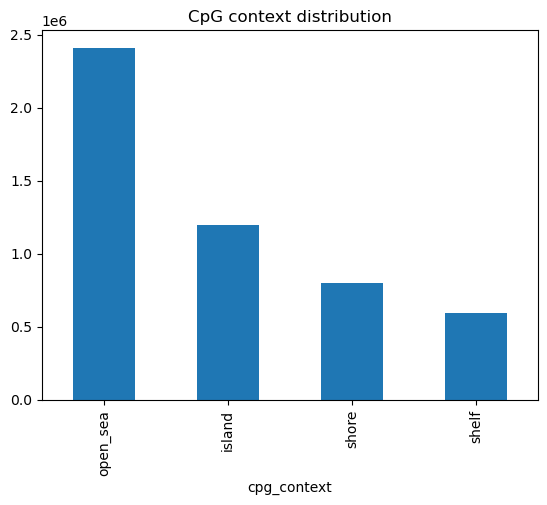

In [9]:
matrix_annotated["cpg_context"].value_counts().plot(kind="bar", title="CpG context distribution")

# Gene context annotation

In [10]:
!wget -P annotations \
  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz


--2025-07-04 12:59:43--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37991892 (36M) [application/x-gzip]
Saving to: ‘annotations/gencode.v19.annotation.gtf.gz.4’

gencode.v19.annotat 100%[===================>]  36.23M  51.4MB/s    in 0.7s    

2025-07-04 12:59:44 (51.4 MB/s) - ‘annotations/gencode.v19.annotation.gtf.gz.4’ saved [37991892/37991892]



In [11]:
import gzip

def extract_gene_features(gtf_path):
    genes = []
    with gzip.open(gtf_path, 'rt') as f:
        for line in f:
            if line.startswith("#"): continue
            parts = line.strip().split('\t')
            if parts[2] != "gene": continue
            chrom, source, feature, start, end, score, strand, frame, attr = parts
            attr_dict = dict([tuple(x.strip().replace('"','').split(' ')) 
                              for x in attr.strip(';').split('; ') if ' ' in x])
            genes.append((chrom, int(start), int(end), strand, attr_dict.get("gene_name", "NA")))
    return pd.DataFrame(genes, columns=["chr", "start", "end", "strand", "gene"])

genes = extract_gene_features("annotations/gencode.v19.annotation.gtf.gz")

# Promoter windows
tss = genes["start"].where(genes["strand"] == "+", genes["end"])
promoters = genes.copy()
promoters["start"] = tss - 1500
promoters["start"] = promoters["start"].clip(lower=0)
promoters["end"] = tss + 500


promoters = promoters[["chr", "start", "end", "gene"]].copy()
promoters["label"] = "promoter"


# Gene bodies
gene_bodies = genes[["chr", "start", "end", "gene"]].copy()
gene_bodies["label"] = "gene_body"


In [12]:
import pyranges as pr

# CpGs from matrix
cpg_df = matrix[["chr", "cpg_pos"]].copy()
cpg_df = cpg_df.rename(columns={"chr": "Chromosome", "cpg_pos": "Start"})
cpg_df["End"] = cpg_df["Start"] + 1
cpgs = pr.PyRanges(cpg_df)

# Convert annotations
promoters_pr = pr.PyRanges(promoters.rename(columns={"chr":"Chromosome", "start":"Start", "end":"End"}))
genes_pr     = pr.PyRanges(gene_bodies.rename(columns={"chr":"Chromosome", "start":"Start", "end":"End"}))

# Annotate
anno_promoters = cpgs.join(promoters_pr).df[["Chromosome", "Start", "label"]]
anno_genebody  = cpgs.join(genes_pr).df[["Chromosome", "Start", "label"]]

# Combine: priority = promoter > gene_body > intergenic
annots = pd.concat([anno_genebody, anno_promoters], ignore_index=True).drop_duplicates(["Chromosome", "Start"], keep="last")
annots.columns = ["chr", "cpg_pos", "gene_context"]

matrix_gene_annot = matrix.merge(annots, on=["chr", "cpg_pos"], how="left")
matrix_gene_annot["gene_context"] = matrix_gene_annot["gene_context"].fillna("intergenic")


KeyboardInterrupt: 

In [ ]:
matrix_gene_annot

,chr,cpg_pos,1st_PB1,1st_PB2,1st_PB3,2-cell1,2-cell2,2nd_PB1,2nd_PB2,4-cell1,...,Sperm1,Sperm2,Sperm3,Sperm4,TE1,TE2,TE3,Zygote1,Zygote2,gene_context
0,chr1,10609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter
1,chr1,10617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter
2,chr1,10620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter
3,chr1,10631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter
4,chr1,10867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374954,chrY,59357712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,0.6,1.000000,NaN,NaN,0.333333,NaN,NaN,gene_body
4374955,chrY,59357736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.0,0.666667,NaN,NaN,0.666667,NaN,NaN,gene_body
4374956,chrY,59357765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gene_body
4374957,chrY,59357786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gene_body


In [ ]:
regions = pd.concat([promoters, gene_bodies], ignore_index=True)
regions["region_type"] = regions["label"]
regions["region_id"] = regions["region_type"] + ":" + regions["gene"]
regions

,chr,start,end,gene,label,region_type,region_id
0,chr1,10369,12369,DDX11L1,promoter,promoter,promoter:DDX11L1
1,chr1,28306,30306,WASH7P,promoter,promoter,promoter:WASH7P
2,chr1,28054,30054,MIR1302-11,promoter,promoter,promoter:MIR1302-11
3,chr1,34581,36581,FAM138A,promoter,promoter,promoter:FAM138A
4,chr1,50973,52973,OR4G4P,promoter,promoter,promoter:OR4G4P
...,...,...,...,...,...,...,...
115635,chrM,14149,14673,MT-ND6,gene_body,gene_body,gene_body:MT-ND6
115636,chrM,14674,14742,MT-TE,gene_body,gene_body,gene_body:MT-TE
115637,chrM,14747,15887,MT-CYB,gene_body,gene_body,gene_body:MT-CYB
115638,chrM,15888,15953,MT-TT,gene_body,gene_body,gene_body:MT-TT


In [ ]:
regions_pr = pr.PyRanges(regions.rename(columns={
    "chr": "Chromosome", "start": "Start", "end": "End"
}))
anno = cpgs.join(regions_pr).df[["Chromosome", "Start", "region_id", "region_type", "gene"]]
anno.columns = ["chr", "cpg_pos", "region_id", "region_type", "gene"]
priority_order = {"promoter": 2, "gene_body": 1}
anno["priority"] = anno["region_type"].map(priority_order)
anno = anno.sort_values("priority", ascending=False)
anno = anno.drop_duplicates(["chr", "cpg_pos"], keep="first")
anno

,chr,cpg_pos,region_id,region_type,gene,priority
0,chr1,10609,promoter:DDX11L1,promoter,DDX11L1,2
2102673,chr10,28821682,promoter:WAC-AS1,promoter,WAC-AS1,2
2102066,chr10,28287981,promoter:RP11-218D6.4,promoter,RP11-218D6.4,2
2102064,chr10,28287973,promoter:RP11-218D6.4,promoter,RP11-218D6.4,2
2102061,chr10,28287965,promoter:RP11-218D6.4,promoter,RP11-218D6.4,2
...,...,...,...,...,...,...
597794,chr2,197164521,gene_body:HECW2,gene_body,HECW2,1
597793,chr2,197164513,gene_body:HECW2,gene_body,HECW2,1
597792,chr2,197164480,gene_body:HECW2,gene_body,HECW2,1
597791,chr2,197164449,gene_body:HECW2,gene_body,HECW2,1


In [ ]:
matrix_gene_annot = matrix.merge(anno.drop(columns="priority"), on=["chr", "cpg_pos"], how="left")

# Create unique IDs for groups of consecutive intergenic CpG sites
matrix_gene_annot = matrix_gene_annot.sort_values(["chr", "cpg_pos"])

def assign_intergenic_group_ids(df):
    df = df.copy()
    df["is_intergenic"] = df["region_id"].isna()

    # Identify group breaks by chromosome and intergenic status
    df["group_change"] = (df["is_intergenic"] != df["is_intergenic"].shift()) | (df["chr"] != df["chr"].shift())
    df["group_id"] = df["group_change"].cumsum()

    # Subset intergenic CpGs and calculate group boundaries
    intergenic_df = df[df["is_intergenic"]]
    group_info = (
        intergenic_df.groupby("group_id")
        .agg(chr=("chr", "first"), start=("cpg_pos", "min"), end=("cpg_pos", "max"))
    )
    group_info["region_id"] = (
        "intergenic:" + group_info["chr"] + ":" +
        group_info["start"].astype(str) + "-" + group_info["end"].astype(str)
    )

    # Map region_id back to original df
    df = df.merge(group_info["region_id"], how="left", left_on="group_id", right_index=True, suffixes=('', '_new'))
    df["region_id"] = df["region_id"].fillna(df["region_id_new"])

    # Final cleanup
    df = df.drop(columns=["is_intergenic", "group_change", "group_id", "region_id_new"])
    return df


matrix_gene_annot = assign_intergenic_group_ids(matrix_gene_annot)

matrix_gene_annot["region_type"] = matrix_gene_annot["region_type"].fillna("intergenic")
matrix_gene_annot["gene"] = matrix_gene_annot["gene"].fillna("NA")
matrix_gene_annot

,chr,cpg_pos,1st_PB1,1st_PB2,1st_PB3,2-cell1,2-cell2,2nd_PB1,2nd_PB2,4-cell1,...,Sperm3,Sperm4,TE1,TE2,TE3,Zygote1,Zygote2,region_id,region_type,gene
0,chr1,10609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1
1,chr1,10617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1
2,chr1,10620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1
3,chr1,10631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1
4,chr1,10867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374954,chrY,59357712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.6,1.000000,NaN,NaN,0.333333,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10
4374955,chrY,59357736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.666667,NaN,NaN,0.666667,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10
4374956,chrY,59357765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10
4374957,chrY,59357786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10


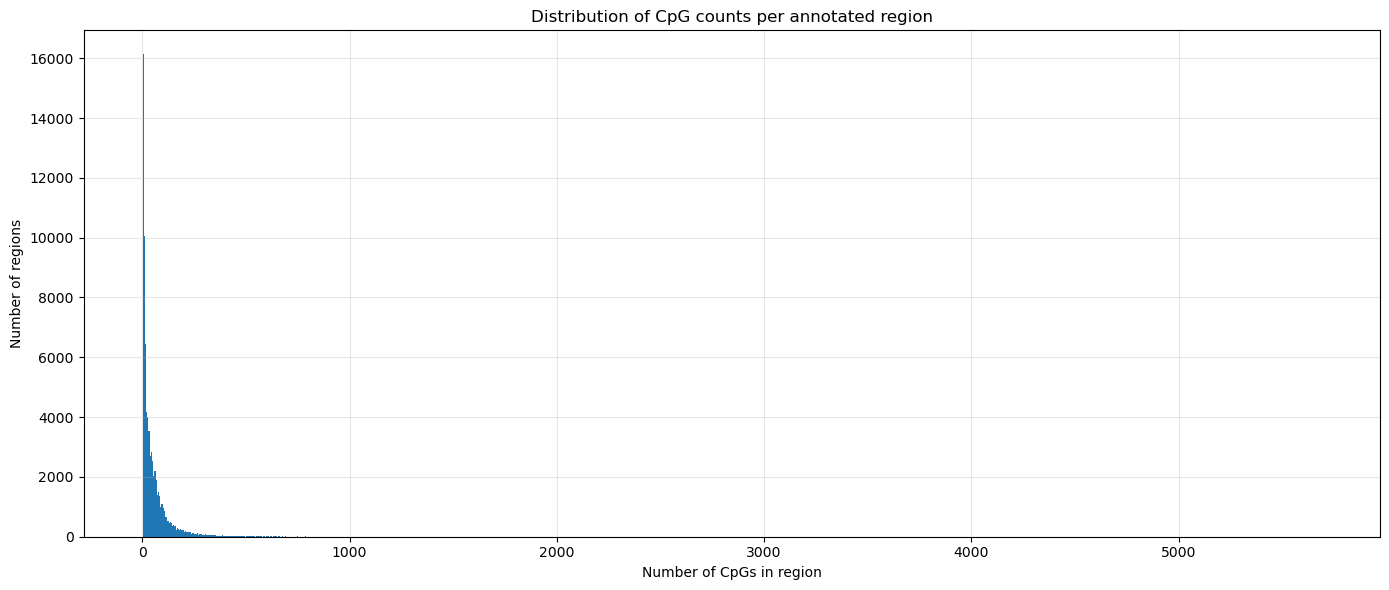

In [ ]:

import matplotlib.pyplot as plt

# Filter to only annotated CpGs (excluding 'intergenic')
region_counts = matrix_gene_annot[matrix_gene_annot["region_id"] != "intergenic"]["region_id"].value_counts()

# Plot
plt.figure(figsize=(14, 6))
plt.hist(region_counts.values, bins=1000)
plt.xlabel("Number of CpGs in region")
plt.ylabel("Number of regions")
plt.title("Distribution of CpG counts per annotated region")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Merge back into your matrix
annotated.columns = ["chr", "cpg_pos", "cpg_context"]
matrix_annotated = matrix_gene_annot.merge(annotated, on=["chr", "cpg_pos"], how="left")
matrix_annotated["cpg_context"] = matrix_annotated["cpg_context"].fillna("open_sea")
matrix_annotated

,chr,cpg_pos,1st_PB1,1st_PB2,1st_PB3,2-cell1,2-cell2,2nd_PB1,2nd_PB2,4-cell1,...,Sperm4,TE1,TE2,TE3,Zygote1,Zygote2,region_id,region_type,gene,cpg_context
0,chr1,10609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1,open_sea
1,chr1,10617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1,open_sea
2,chr1,10620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1,open_sea
3,chr1,10631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1,open_sea
4,chr1,10867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,promoter:DDX11L1,promoter,DDX11L1,open_sea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002167,chrY,59357712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,0.333333,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10,open_sea
5002168,chrY,59357736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.666667,NaN,NaN,0.666667,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10,open_sea
5002169,chrY,59357765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10,open_sea
5002170,chrY,59357786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,gene_body:AJ271736.10,gene_body,AJ271736.10,open_sea


In [ ]:
matrix_annotated["cpg_context"].value_counts()

cpg_context
open_sea    2411210
island      1195000
shore        800087
shelf        595875
Name: count, dtype: int64

In [ ]:
matrix_annotated.to_parquet("data/GSE49828_methylation_matrix_annotated.parquet", index=False)